### **Libraries**

In [1]:
import psycopg2 #to connect to a local PostgreSQL database server

### **Connecting to the PostgreSQL Docker instance** and **Creating a Database "weather"** 

In [4]:
#connect to a PostgreSQL server running on 127.0.0.1 (localhost) using the username dap and password dap
try:
    dbConnection = psycopg2.connect(
        user="dap",                   # PostgreSQL username (from postgresql.env)
        password="dap",               # PostgreSQL password (from postgresql.env)
        host="127.0.0.1",             # Hostname (localhost because Docker forwards the port to the local machine)
        port="5432",                  # PostgreSQL default port
        database="postgres"           # Default database (can be postgres or another name)
    )
    #now sets the connection to autocommit mode. This is required because the CREATE DATABASE command cannot be run inside a transaction block, and autocommit ensures each command runs immediately
    dbConnection.set_isolation_level(0)  # Set to AUTOCOMMIT mode
    #creates a cursor object which is used to send SQL commands to the database
    dbCursor = dbConnection.cursor()     # Create a cursor to execute SQL commands
    #executes the SQL command CREATE DATABASE "weather" to create the new database
    dbCursor.execute('CREATE DATABASE weather;')  # SQL command to create a new database
    dbCursor.close()                     # Close the cursor after executing the command

#If any part of the try block fails, the except block will catch the error and print a message to the console
except (Exception, psycopg2.Error) as dbError:
    print("Error while connecting to PostgreSQL:", dbError)
#safely close the initial connection to the postgres database
finally:
    if 'dbConnection' in locals() and dbConnection:
        dbConnection.close()  # Ensure the connection is closed


### **Creating a table on the database**

In [5]:
import psycopg2

# Define the SQL query to create the table
create_table_sql = """
CREATE TABLE IF NOT EXISTS weather (
    date_time timestamp PRIMARY KEY,
    rain numeric(5,1),
    temp numeric(5,1),
    wetb numeric(5,1),
    dewpt numeric(5,1),
    vappr numeric(5,1),
    rhum integer,
    msl numeric(7,1),
    wdsp integer,
    wddir integer,
    ww integer,
    w integer,
    sun numeric(5,1),
    vis integer,
    clht integer,
    clamt integer
);
"""

try:
    # Reconnect to the database
    dbConnection = psycopg2.connect(
        user="dap",
        password="dap",
        host="127.0.0.1",
        port="5432",
        database="weather"  # Ensure you're connecting to the correct database
    )
    dbConnection.set_isolation_level(0)  # AUTOCOMMIT

    # Create a cursor object
    dbCursor = dbConnection.cursor()

    # Execute the SQL query to create the table
    dbCursor.execute(create_table_sql)
    print("Table created successfully.")

    # Close the cursor
    dbCursor.close()

except (Exception, psycopg2.Error) as dbError:
    print(f"Error while creating the table: {dbError}")

finally:
    if dbConnection:
        dbConnection.close()  # Close the connection when done


Table created successfully.


### **Populating the newly-created table**

In [7]:
import csv
import psycopg2

# Path to your weather CSV file
csv_file_path = 'weather.csv'

# Define the SQL query to insert data into the weather table
insert_query = """
    INSERT INTO weather (date_time, rain, temp, wetb, dewpt, vappr, rhum, msl, wdsp, wddir, ww, w, sun, vis, clht, clamt)
    VALUES (TO_TIMESTAMP('{}', 'DD/MM/YYYY HH24:mi'), {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {});
"""

try:
    # Reconnect to the database
    dbConnection = psycopg2.connect(
        user="dap",
        password="dap",
        host="127.0.0.1",
        port="5432",
        database="weather"
    )
    dbConnection.set_isolation_level(0)  # AUTOCOMMIT
    dbCursor = dbConnection.cursor()

    # Open the CSV file and read the data
    with open(csv_file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header row

        # Insert each row from the CSV into the database
        for row in reader:
            dbCursor.execute(insert_query.format(*row))

    # Commit the changes to the database
    dbConnection.commit()

    print("Data inserted successfully.")

except (Exception, psycopg2.Error) as dbError:
    print(f"Error while inserting data: {dbError}")

finally:
    if dbCursor:
        dbCursor.close()
    if dbConnection:
        dbConnection.close()


Data inserted successfully.


### **Data analysis and Querying the table**

In [8]:
import pandas as pd
import psycopg2

# Define the SQL query to calculate the monthly averages
query_monthly_averages = """
    SELECT
        EXTRACT(MONTH FROM date_time) AS month,
        AVG(temp) as avg_temp,
        AVG(wdsp) AS avg_wdsp
    FROM
        weather
    GROUP BY
        month
    ORDER BY
        month;
"""

try:
    # Reconnect to the database
    dbConnection = psycopg2.connect(
        user="dap",
        password="dap",
        host="127.0.0.1",
        port="5432",
        database="weather"
    )

    # Use pandas to run the SQL query and load the result into a dataframe
    weather_dataframe = pd.read_sql(query_monthly_averages, dbConnection)

    # Display the first few rows of the result
    print(weather_dataframe)

except (Exception, psycopg2.Error) as dbError:
    print(f"Error while querying the database: {dbError}")

finally:
    if dbConnection:
        dbConnection.close()


    month   avg_temp  avg_wdsp
0     1.0   5.047258  2.000000
1     2.0   5.231678  2.000000
2     3.0   6.100524  2.002151
3     4.0   8.088000  1.999722
4     5.0  10.867245  2.000000
5     6.0  13.610611  2.000000
6     7.0  15.414274  2.000000
7     8.0  14.676667  2.000000
8     9.0  13.011500  2.001667
9    10.0  10.680484  2.000000
10   11.0   7.322407  2.000000
11   12.0   5.892727  2.000000


/var/folders/dd/7j7jpzfs0s5gs3q_ppg_0txr0000gn/T/ipykernel_55314/2621246412.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_dataframe = pd.read_sql(query_monthly_averages, dbConnection)


### **Visualise bar chart of temperatures by month**

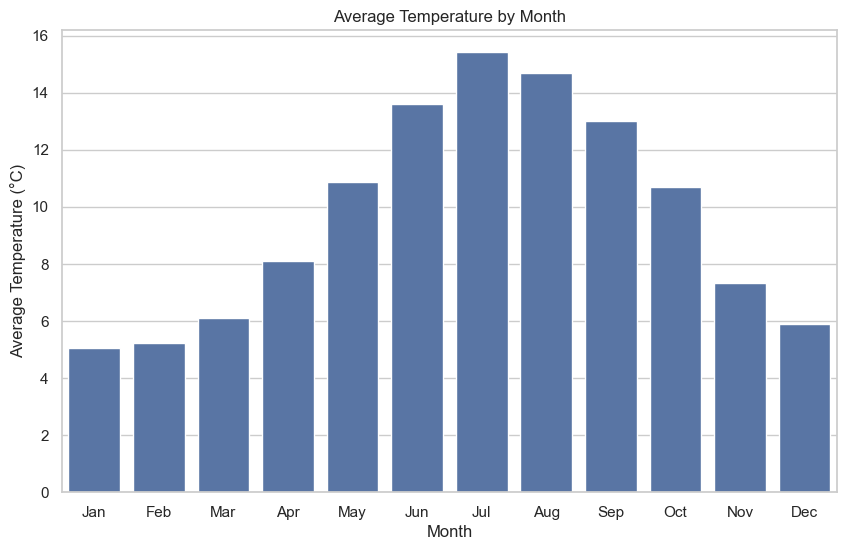

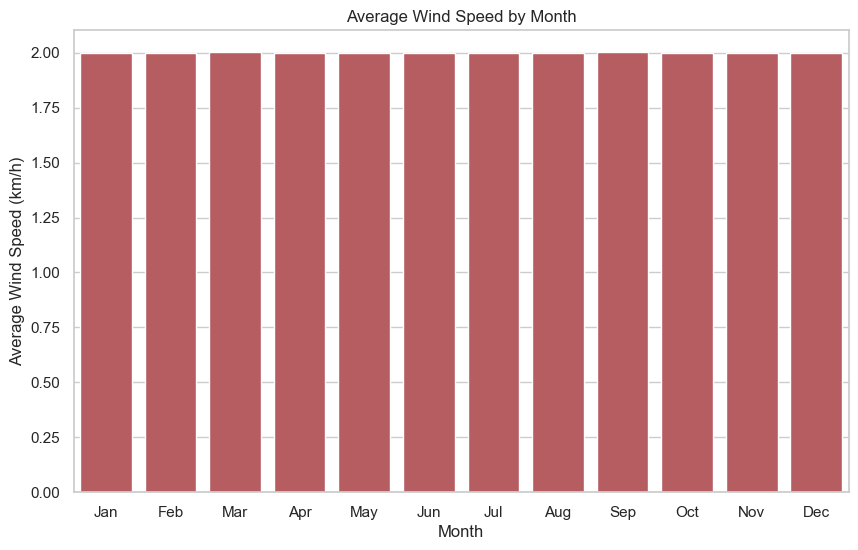

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot for average temperature by month
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="avg_temp", data=weather_dataframe, color="b")
plt.title("Average Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

# Create a bar plot for average wind speed by month
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="avg_wdsp", data=weather_dataframe, color="r")
plt.title("Average Wind Speed by Month")
plt.xlabel("Month")
plt.ylabel("Average Wind Speed (km/h)")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


### **Visualise daily minimum temperature and dewpoint**

In [10]:
import pandas as pd
import psycopg2

# SQL query to get the daily minimum temperature and dew point
query_temp_dewpt = """
    SELECT
        date(date_time) AS obs_date,
        MIN(temp) as min_temp,
        MIN(dewpt) as min_dewpt
    FROM
        weather
    GROUP BY
        obs_date;
"""

try:
    # Reconnect to the database
    dbConnection = psycopg2.connect(
        user="dap",
        password="dap",
        host="127.0.0.1",
        port="5432",
        database="weather"
    )

    # Use pandas to run the SQL query and load the result into a dataframe
    temp_dewpt_df = pd.read_sql(query_temp_dewpt, dbConnection)

    # Display the first few rows of the result
    print(temp_dewpt_df.head())

except (Exception, psycopg2.Error) as dbError:
    print(f"Error while querying the database: {dbError}")

finally:
    if dbConnection:
        dbConnection.close()


     obs_date  min_temp  min_dewpt
0  2013-02-11       3.1        0.8
1  2010-10-11       4.2        4.1
2  2014-12-21       7.2        3.8
3  2011-11-05       1.1        0.9
4  2015-08-07       9.3        7.6


/var/folders/dd/7j7jpzfs0s5gs3q_ppg_0txr0000gn/T/ipykernel_55314/3544426755.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temp_dewpt_df = pd.read_sql(query_temp_dewpt, dbConnection)


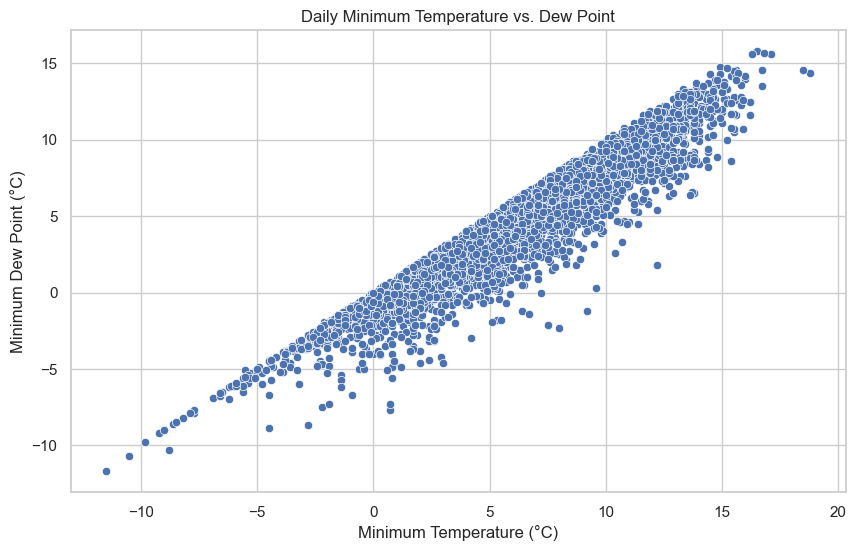

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Create a scatterplot for temperature and dew point
plt.figure(figsize=(10, 6))
sns.scatterplot(x="min_temp", y="min_dewpt", data=temp_dewpt_df)
plt.title("Daily Minimum Temperature vs. Dew Point")
plt.xlabel("Minimum Temperature (°C)")
plt.ylabel("Minimum Dew Point (°C)")
plt.show()
